<a href="https://colab.research.google.com/github/Mukulgoel457/Financial-Analysis-using-Signal-Proceessing-Tools/blob/main/Project%20code(py).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import yfinance as yf
TCSdata = yf.download("TCS.NS", start="2011-01-01", end="2023-03-01")

[*********************100%%**********************]  1 of 1 completed


In [22]:
# Preprocessing of data
import pandas as pd
dataset = TCSdata.copy()
dataset = dataset.reset_index()
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)
dataset = dataset['Close'].to_frame()

In [23]:
!pip install pmdarima

In [24]:
from pmdarima.arima import auto_arima

model = auto_arima(dataset['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=28716.779, Time=5.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28723.535, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28725.169, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28725.141, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28724.486, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28724.327, Time=3.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28724.039, Time=3.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=28711.270, Time=14.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=28724.743, Time=6.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=28720.500, Time=10.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=28720.129, Time=9.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=28711.610, Time=8.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=28724.519, Time=4.02 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=28719.940, Time=10.49 sec
 ARIMA(3,1,2)(0,

In [25]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Defining the ARIMA model
def arima_forecast(history):
    # Fitting the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()

    # Making the prediction
    output = model_fit.forecast()
    forecasted_value = output[0]
    return forecasted_value

# Splitting data into train and test sets
X = dataset.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generating a prediction
    forecasted_value = arima_forecast(history)
    predictions.append(forecasted_value)
    # Adding the predicted value to the training set
    obs = test[t]
    history.append(obs)

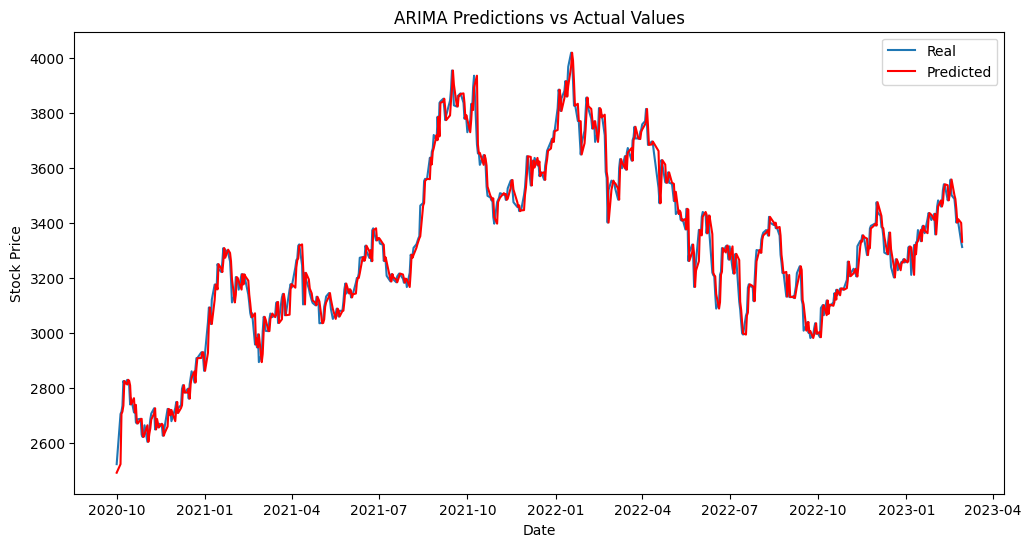

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset.iloc[size:,:].index, test, label='Real')
plt.plot(dataset.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


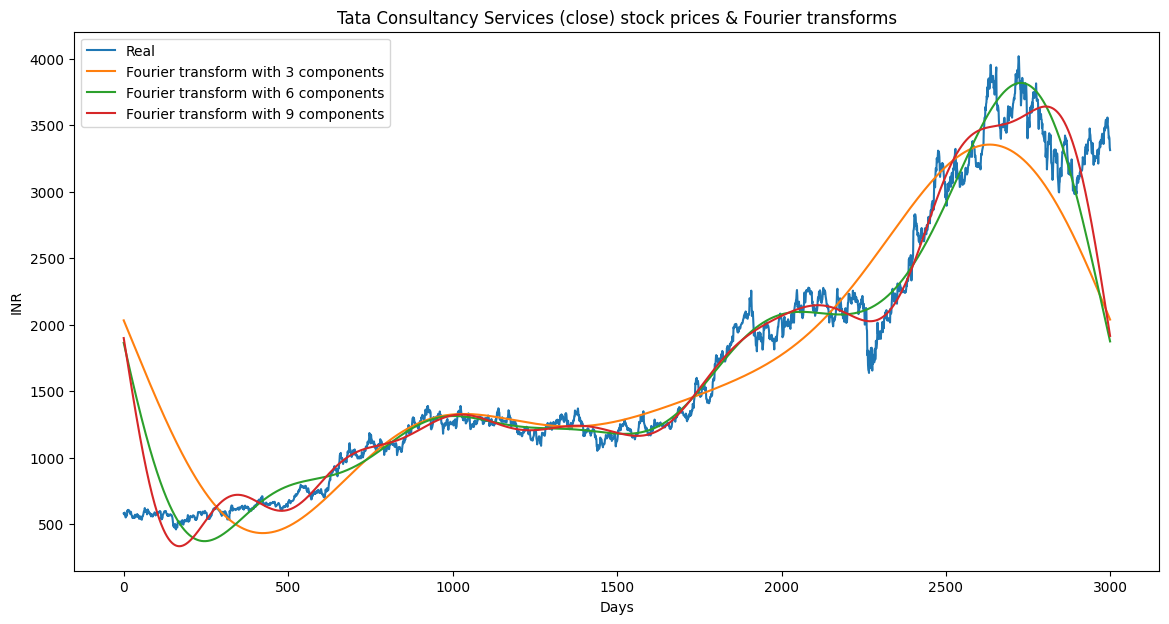

In [27]:
# Calculation of the Fourier Transform
data_FT = dataset[['Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

# Plot the Fourier Transforms
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(np.asarray(data_FT['Close'].tolist()),  label='Real')
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(close_fft); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.xlabel('Days')
plt.ylabel('INR')
plt.title('Tata Consultancy Services (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [28]:
#Technical Indicators:
# EMA
def EMA(close, period=20):
    return close.ewm(span=period, adjust=False).mean()

#RSI
def RSI(close, period=14):
    delta = close.diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    avg_gain = gain.rolling(period).mean()
    avg_loss = abs(loss.rolling(period).mean())
    rs = avg_gain / avg_loss
    RSI = 100.0 - (100.0 / (1.0 + rs))
    return RSI

#MACD
def MACD(close, fast_period=12, slow_period=26, signal_period=9):
    fast_EMA = close.ewm(span=fast_period, adjust=False).mean()
    slow_EMA = close.ewm(span=slow_period, adjust=False).mean()
    MACD_line = fast_EMA - slow_EMA
    signal_line = MACD_line.ewm(span=signal_period, adjust=False).mean()
    histogram = MACD_line - signal_line
    return MACD_line

#OBV
def OBV(close, volume):
    OBV = np.where(close > close.shift(), volume, np.where(close < close.shift(), -volume, 0)).cumsum()
    return OBV

In [29]:
# Add technical indicators to dataset DF
dataset['EMA_20'] = EMA(TCSdata["Close"], 20)
dataset['EMA_50'] = EMA(TCSdata["Close"], 50)
dataset['EMA_100'] = EMA(TCSdata["Close"], 100)

dataset['RSI'] = RSI(TCSdata["Close"])
dataset['MACD'] = MACD(TCSdata["Close"])
dataset['OBV'] = OBV(TCSdata["Close"], TCSdata["Volume"])

In [30]:
# Creating arima DF using predictions
arima_df = pd.DataFrame(history, index=dataset.index, columns=['ARIMA'])

# Setting Fourier Transforms DF
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(dataset.index)
fft_df.set_index('index', inplace=True)
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

# Technical Indicators DF
technical_indicators_df = dataset[['EMA_20', 'EMA_50', 'EMA_100', 'RSI', 'MACD', 'OBV', 'Close']]

# Merge DF
merged_df = pd.concat([arima_df, fft_df_real, fft_df_imag, technical_indicators_df], axis=1)
merged_df = merged_df.dropna()
merged_df

,ARIMA,Fourier_real,Fourier_imag,EMA_20,EMA_50,EMA_100,RSI,MACD,OBV,Close
2011-01-21,605.825012,-17652.998344,8.415764e+04,581.672435,579.306949,578.975477,59.626440,4.687641,-1943024,605.825012
2011-01-24,604.599976,-11907.186833,9.307921e+04,583.856011,580.298833,579.482893,62.044477,5.881674,-3959702,604.599976
2011-01-25,594.275024,32436.950244,8.896299e+04,584.848298,580.846919,579.775806,55.401482,5.926499,-6426796,594.275024
2011-01-27,599.700012,-8411.359401,1.067689e+05,586.262747,581.586256,580.170345,55.090059,6.326843,-1712678,599.700012
2011-01-28,590.674988,-5332.976687,6.031880e+04,586.682960,581.942676,580.378358,57.410948,5.848457,-4727256,590.674988
...,...,...,...,...,...,...,...,...,...,...
2023-02-22,3401.550049,-103485.623273,-1.129605e+05,3460.957484,3400.883804,3348.700150,42.922459,26.665707,290448985,3401.550049
2023-02-23,3413.800049,-212262.123807,-3.867570e+05,3456.466300,3401.390323,3349.989256,41.566129,19.864550,291890555,3413.800049
2023-02-24,3400.449951,92458.187576,-6.530799e+05,3451.131410,3401.353446,3350.988478,42.508195,13.244667,290912963,3400.449951
2023-02-27,3331.850098,-39411.580621,-9.780540e+05,3439.771285,3398.627825,3350.609500,34.473643,2.434860,289784941,3331.850098


In [31]:
# Separate in Train and Test Dfs
train_size = int(len(merged_df) * 0.8)
train_df, test_df = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.drop('Close', axis=1))
test_scaled = scaler.transform(test_df.drop('Close', axis=1))

# Convert the scaled data back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns[:-1], index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns[:-1], index=test_df.index)

# Merge the scaled features with the target variable
train_scaled_df['Close'] = train_df['Close']
test_scaled_df['Close'] = test_df['Close']

# Split the scaled data into Features and Label
X_train = train_scaled_df.iloc[:, :-1].values
y_train = train_scaled_df.iloc[:, -1].values
X_test = test_scaled_df.iloc[:, :-1].values
y_test = test_scaled_df.iloc[:, -1].values

In [33]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='MSE')


# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')

# Train the model with early stopping callback
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop], shuffle=False)

Epoch 1/1000
75/75 [==============================] - 1s 5ms/step - loss: 1905333.0000 - val_loss: 11037073.0000
Epoch 2/1000
75/75 [==============================] - 0s 3ms/step - loss: 1890993.3750 - val_loss: 10935310.0000
Epoch 3/1000
75/75 [==============================] - 0s 3ms/step - loss: 1851311.3750 - val_loss: 10685280.0000
Epoch 4/1000
75/75 [==============================] - 0s 3ms/step - loss: 1770026.3750 - val_loss: 10218480.0000
Epoch 5/1000
75/75 [==============================] - 0s 3ms/step - loss: 1635022.2500 - val_loss: 9488189.0000
Epoch 6/1000
75/75 [==============================] - 0s 3ms/step - loss: 1442262.5000 - val_loss: 8482473.0000
Epoch 7/1000
75/75 [==============================] - 0s 3ms/step - loss: 1200901.3750 - val_loss: 7257807.0000
Epoch 8/1000
75/75 [==============================] - 0s 3ms/step - loss: 930670.8750 - val_loss: 5887670.0000
Epoch 9/1000
75/75 [==============================] - 0s 3ms/step - loss: 661117.8125 - val_loss: 452

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

import numpy as np
y_pred = model.predict(X_test)

# Calculate test metrics
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100

print(f"Mean Squared Error (MSE): {MSE}")
print(f"Mean Absolute Error (MAE): {MAE}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")

19/19 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 5730.0816041989665
Mean Absolute Error (MAE): 45.91661781132421
R2 Score: 0.9386434148951776
Explained Variance Score: 0.942329284974265
Mean Absolute Percentage Error (MAPE): 10.559450152113953
Mean Percentage Error (MPE): -1.443462169871217


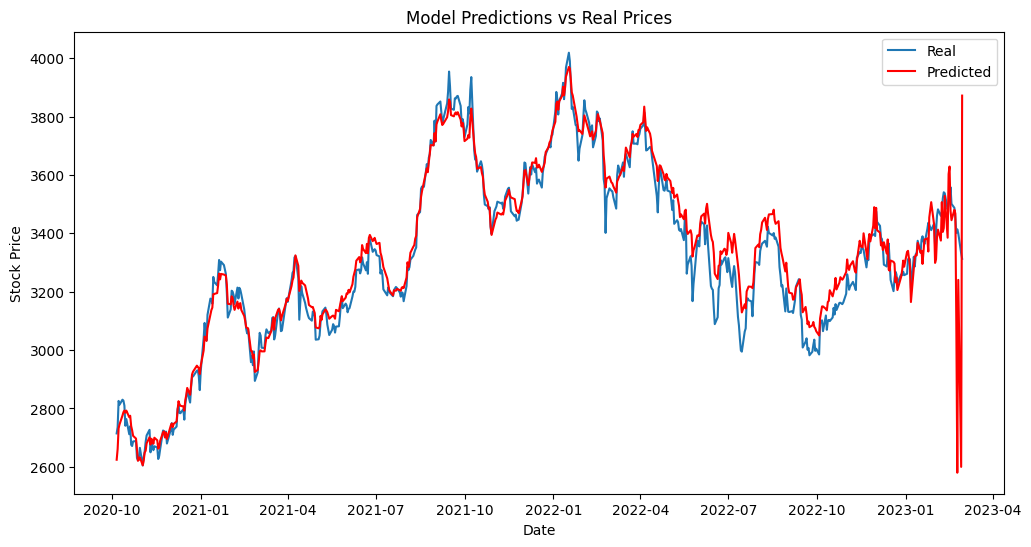

In [35]:
# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_scaled_df.index, y_test, label='Real')
plt.plot(test_scaled_df.index, y_pred, color='red', label='Predicted')
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()